In [312]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

In [313]:
bens_cand = pd.read_csv('bem_candidato_2018_BRASIL.csv')
consulta_cand = pd.read_csv('consulta_cand_2018_BRASIL.csv')

In [314]:
# Fundindo os dataframes
bens_consulta = pd.merge(consulta_cand, bens_cand, "inner", "SQ_CANDIDATO")

In [315]:
# Limitando escopo para primeiro turno, para candidaturas deferidas, para eleições estaduais no Estado
# de São Paulo e para o cargo de deputado estadual
bens_consulta = bens_consulta[
    (bens_consulta['DS_DETALHE_SITUACAO_CAND'].isin(['DEFERIDO', 'DEFERIDO COM RECURSO'])) & 
    (bens_consulta['NR_TURNO'] == 1) &
    (bens_consulta['SG_UF_x'] == 'SP') &
    (bens_consulta['DS_CARGO'] == 'DEPUTADO ESTADUAL')
]

# Dropando colunas desnecessárias
bens_consulta = bens_consulta.drop(columns=[
    "CD_ELEICAO_x",
    "CD_ELEICAO_y",
    "TP_ABRANGENCIA",
    "CD_TIPO_ELEICAO_x",
    "CD_TIPO_ELEICAO_y",
    "NM_TIPO_ELEICAO_x",
    "NM_TIPO_ELEICAO_y",
    "DT_ELEICAO_x",
    "DT_ELEICAO_y",
    "DS_ELEICAO_x",
    "DS_ELEICAO_y",
    "SG_UF_x",
    "SG_UF_y",
    "SG_UE_x",
    "SG_UE_y",
    "NM_UE_x",
    "NM_UE_y",
    "CD_CARGO",
    "DS_CARGO",
    "NR_PARTIDO",
    "SG_PARTIDO",
    "SQ_COLIGACAO",
    "DS_COMPOSICAO_COLIGACAO",
    "TP_AGREMIACAO",
    "SQ_CANDIDATO",
    "NR_CANDIDATO",
    "NM_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NM_SOCIAL_CANDIDATO",
    "NR_CPF_CANDIDATO",
    "NM_EMAIL",
    "NR_TITULO_ELEITORAL_CANDIDATO",
    "CD_NACIONALIDADE",
    "CD_MUNICIPIO_NASCIMENTO",
    "NM_MUNICIPIO_NASCIMENTO",
    "DT_NASCIMENTO",
    "CD_GENERO",
    "CD_GRAU_INSTRUCAO",
    "CD_ESTADO_CIVIL",
    "CD_COR_RACA",
    "CD_OCUPACAO",
    "CD_TIPO_BEM_CANDIDATO",
    "DS_TIPO_BEM_CANDIDATO",
    "DS_BEM_CANDIDATO",
    "CD_SITUACAO_CANDIDATURA",
    "DS_SITUACAO_CANDIDATURA",
    "CD_DETALHE_SITUACAO_CAND",
    "DS_DETALHE_SITUACAO_CAND",
    "NR_DESPESA_MAX_CAMPANHA",
    "DT_GERACAO_x",
    "DT_GERACAO_y",
    "HH_GERACAO_x",
    "HH_GERACAO_y",
    "ANO_ELEICAO_x",
    "ANO_ELEICAO_y",
    "NR_TURNO",
    "CD_SIT_TOT_TURNO",
    "ST_DECLARAR_BENS",
    "NR_PROTOCOLO_CANDIDATURA",
    "NR_ORDEM_CANDIDATO",
    "NR_PROCESSO",
    "DT_ULTIMA_ATUALIZACAO",
    "HH_ULTIMA_ATUALIZACAO"
])

In [316]:
# Convertendo valor de declaração para numérico
bens_consulta['VR_BEM_CANDIDATO'] = bens_consulta['VR_BEM_CANDIDATO'].str.replace(',', '.')
bens_consulta['VR_BEM_CANDIDATO'] = bens_consulta['VR_BEM_CANDIDATO'].astype(float)

In [317]:
# Transformando coluna idade em categórica
idade = pd.cut(
    bens_consulta['NR_IDADE_DATA_POSSE'],
    bins=[0, 29, 59, 99],
    labels=['JOVEM', 'ADULTO', 'IDOSO']
)
bens_consulta.insert(4, 'CLASSIFICACAO_ETARIA', idade)
bens_consulta = bens_consulta.drop(columns=['NR_IDADE_DATA_POSSE'])

# Convertendo coluna de categoria para string
bens_consulta['CLASSIFICACAO_ETARIA'] = bens_consulta['CLASSIFICACAO_ETARIA'].astype('object')

In [318]:
# Diminuindo o número de profissões
ocupacao = bens_consulta['DS_OCUPACAO'].value_counts().rename_axis('DS_OCUPACAO').reset_index(name='counts')
profissoes_com_menos_de_10_ocorrencias = ocupacao[ocupacao['counts'] < 10]
profissoes_com_menos_de_10_ocorrencias = profissoes_com_menos_de_10_ocorrencias.iloc[:, 0]

bens_consulta['DS_OCUPACAO'] = np.where(
    bens_consulta['DS_OCUPACAO'].isin(profissoes_com_menos_de_10_ocorrencias),
    'OUTROS',
    bens_consulta['DS_OCUPACAO']
)

In [319]:
# Diminuindo o número de Estados
regioes = {
    'SUL': ['SC', 'PR', 'RS'],
    'NORTE': ['AM', 'AP', 'AC', 'PA', 'RO', 'RR', 'TO'],
    'NORDESTE': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'CENTRO_OESTE': ['GO', 'MT', 'MS'],
    'SUDESTE': ['ES', 'MG', 'RJ', 'SP']
}

for regiao in regioes.keys():
    bens_consulta['SG_UF_NASCIMENTO'] = np.where(
        bens_consulta['SG_UF_NASCIMENTO'].isin(regioes[regiao]),
        regiao,
        bens_consulta['SG_UF_NASCIMENTO']
    )

In [320]:
# Removendo valor estranho de Estado de nascimento
bens_consulta = bens_consulta[bens_consulta['SG_UF_NASCIMENTO'] != 'ZZ']

In [321]:
# Transformando target
import numpy as np

bens_consulta['DS_SIT_TOT_TURNO'] = np.where(
    bens_consulta['DS_SIT_TOT_TURNO'].isin(['SUPLENTE', 'NÃO ELEITO']),
    0,
    bens_consulta['DS_SIT_TOT_TURNO']
)
bens_consulta['DS_SIT_TOT_TURNO'] = np.where(
    bens_consulta['DS_SIT_TOT_TURNO'].isin(['ELEITO POR QP','ELEITO POR MÉDIA','ELEITO']),
    1,
    bens_consulta['DS_SIT_TOT_TURNO']
)


In [322]:
bens_consulta['DS_SIT_TOT_TURNO'].value_counts()

0    5681
1     891
Name: DS_SIT_TOT_TURNO, dtype: int64

In [323]:
bens_consulta.head()

,NM_PARTIDO,NM_COLIGACAO,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CLASSIFICACAO_ETARIA,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,DS_SIT_TOT_TURNO,ST_REELEICAO,VR_BEM_CANDIDATO
18,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,45000.00
19,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,151419.14
20,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,474.28
21,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,362086.34
22,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,30000.00


In [324]:
# Removendo valores nulos
bens_consulta_enc = bens_consulta.dropna()

for column in bens_consulta_enc.columns:
    if 'nan' in column:
        bens_consulta_enc = bens_consulta_enc.drop(columns=column)

In [325]:
bens_consulta_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6572 entries, 18 to 94060
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NM_PARTIDO            6572 non-null   object 
 1   NM_COLIGACAO          6572 non-null   object 
 2   DS_NACIONALIDADE      6572 non-null   object 
 3   SG_UF_NASCIMENTO      6572 non-null   object 
 4   CLASSIFICACAO_ETARIA  6572 non-null   object 
 5   DS_GENERO             6572 non-null   object 
 6   DS_GRAU_INSTRUCAO     6572 non-null   object 
 7   DS_ESTADO_CIVIL       6572 non-null   object 
 8   DS_COR_RACA           6572 non-null   object 
 9   DS_OCUPACAO           6572 non-null   object 
 10  DS_SIT_TOT_TURNO      6572 non-null   object 
 11  ST_REELEICAO          6572 non-null   object 
 12  VR_BEM_CANDIDATO      6572 non-null   float64
dtypes: float64(1), object(12)
memory usage: 718.8+ KB


In [326]:
bens_consulta_enc['DS_GRAU_INSTRUCAO'].unique()

array(['SUPERIOR COMPLETO', 'ENSINO MÉDIO COMPLETO',
       'SUPERIOR INCOMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO',
       'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO MÉDIO INCOMPLETO',
       'LÊ E ESCREVE'], dtype=object)

In [327]:
def de_para_func(df_coluna):
    unique_values = df_coluna.unique()
    dict_map = {}
    for index, value in enumerate(unique_values):
        dict_map[value] = index
    return dict_map

In [358]:
df_knn = bens_consulta_enc[['NM_PARTIDO','ST_REELEICAO','DS_GRAU_INSTRUCAO','DS_SIT_TOT_TURNO']]

In [359]:
df_knn['NM_PARTIDO'] = df_knn['NM_PARTIDO'].map(de_para_func(df_knn['NM_PARTIDO']))

/tmp/ipykernel_11454/1026483401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knn['NM_PARTIDO'] = df_knn['NM_PARTIDO'].map(de_para_func(df_knn['NM_PARTIDO']))


In [360]:
df_knn['ST_REELEICAO'] = df_knn['ST_REELEICAO'].map(de_para_func(df_knn['ST_REELEICAO']))

/tmp/ipykernel_11454/4262610727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knn['ST_REELEICAO'] = df_knn['ST_REELEICAO'].map(de_para_func(df_knn['ST_REELEICAO']))


In [361]:
df_knn['DS_GRAU_INSTRUCAO'] = df_knn['DS_GRAU_INSTRUCAO'].map(de_para_func(df_knn['DS_GRAU_INSTRUCAO']))

/tmp/ipykernel_11454/3696468710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knn['DS_GRAU_INSTRUCAO'] = df_knn['DS_GRAU_INSTRUCAO'].map(de_para_func(df_knn['DS_GRAU_INSTRUCAO']))


In [393]:
from sklearn.preprocessing import OneHotEncoder

# Definindo função para transformar colunas categóricas
def one_hot_encode_feature(data,feature):

    enc = OneHotEncoder()
    
    enc_df = pd.DataFrame(enc.fit_transform(data[[feature]]).toarray())
    enc_df.columns = enc.get_feature_names_out()
    
    new_data = pd.concat([data,enc_df],axis=1)
    new_data.drop(feature,axis=1,inplace=True)
    
    return new_data

df_knn_2 = df_knn
for column in df_knn_2.columns:
    if df_knn_2[column].dtype == object:
        df_knn_2 = one_hot_encode_feature(df_knn_2, column)

In [394]:
#df_knn_2['DS_SIT_TOT_TURNO_1'].unique()
#NM_PARTIDO	ST_REELEICAO	DS_GRAU_INSTRUCAO	DS_SIT_TOT_TURNO_0	DS_SIT_TOT_TURNO_1
df_knn_3 = df_knn_2.dropna()
df_knn_3['DS_SIT_TOT_TURNO_1'].unique()

array([0., 1.])

In [395]:
seed=42
scoring = 'f1'

X = df_knn_3.drop(columns=['DS_SIT_TOT_TURNO_0', 'DS_SIT_TOT_TURNO_1'])
y = df_knn_3['DS_SIT_TOT_TURNO_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [396]:
# Otimizando hiperparâmetros para Decision Tree
lista_etapas = [("dt", DecisionTreeClassifier())]

pipe = Pipeline(lista_etapas)

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrica = make_scorer(f1_score)

params_grid_dt = {"dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 5)} 

grid_dt = GridSearchCV(estimator=pipe,
                       param_grid=params_grid_dt,
                       scoring=metrica,
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)



In [397]:
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 2/5; 1/12] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 3/5; 1/12] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 4/5; 1/12] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 5/5; 1/12] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 1/5; 2/12] START dt__criterion=gini, dt__max_depth=2, dt__splitter=random...
[CV 2/5; 2/12] START dt__criterion=gini, dt__max_depth=2, dt__splitter=random...
[CV 1/5; 1/12] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.500 total time=   0.0s
[CV 2/5; 1/12] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.429 total time=   0.0s
[CV 4/5; 1/12] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.706 total time=   0.0s
[CV 5/5; 1/12] END dt__criterion=gini, dt__max_dept

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(2, 5),
                         'dt__splitter': ['best', 'random']},
             scoring=make_scorer(f1_score), verbose=10)

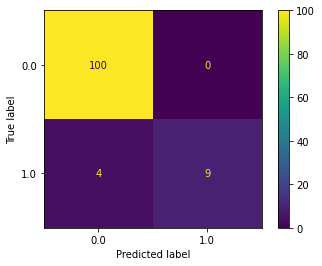

In [398]:
y_pred_dt = grid_dt.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.show()

In [399]:
# Otimizando hiperparâmetros para KNN

lista_etapas = [('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())]

pipe = Pipeline(lista_etapas)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(f1_score)

param_grid_knn= {"knn__weights" : ['uniform', 'distance'],
           "knn__algorithm" : ['ball_tree', 'brute', 'kd_tree'],
           "knn__metric" : ['manhattan', 'euclidean'],
           "knn__n_neighbors" : range(2, 5)}

grid_knn = GridSearchCV(estimator=pipe,
                       param_grid=param_grid_knn,
                       scoring=metrica,
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

In [400]:
grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 6/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 7/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 8/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/36] END knn__algorithm=ball_t

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['ball_tree', 'brute', 'kd_tree'],
                         'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 5),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score), verbose=10)

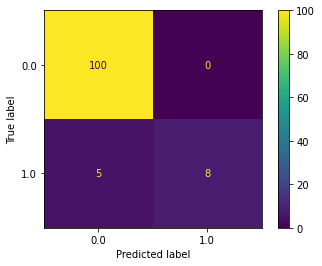

In [402]:
y_pred_knn = grid_knn.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.show()